In [ ]:
import sys
sys.path.append('../..')
import torchvision 
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch as ch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Gumbel
import math

import matplotlib.pyplot as plt
import cox
from cox.utils import Parameters
import cox.store as store
from cox.readers import CollectionReader
import seaborn as sns
import os
import config

from delphi import train
from delphi.cifar_models import vgg11
from delphi.utils import model_utils
from delphi import grad
from delphi import oracle
from delphi.utils.datasets import CIFAR
import delphi.utils.data_augmentation as da
import delphi.utils.constants as consts
import delphi.utils.data_augmentation as da
from delphi.utils.helpers import setup_store_with_metadata
import pickle
import pandas as pd

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# Constants

In [2]:
BASE_STORE = '/home/pstefanou/cifar-10/resnet-18/base/'
BASE_CLASSIFIER_PATH = '/home/pstefanou/cifar-10/resnet-18/base/b78013b8-fc41-41c9-8682-763299796454/checkpoint.pt.best'
LOGIT_BALL_CLASSIFIER = '/home/pstefanou/cifar-10/resnet-18/logit_ball_complement'
STANDARD_CLASSIFIER = '/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement'
DATA_PATH = '/home/pstefanou/data/'

# Experiment Hyperparameters

In [3]:
args = Parameters({ 
    'epochs': 150,
    'workers': 8, 
    'batch_size': 128, 
    'lr': 1e-1, 
    'accuracy': True,
    'momentum': .9, 
    'weight_decay': 5e-4, 
    'save_ckpt_iters': 50,
    'should_save_ckpt': True,
    'log_iters': 1,
#     'custom_lr_multiplier': consts.COSINE, 
    'step_lr': 2000000, 
    'step_lr_gamma': 1.0,
    'validation_split': .8,
    'shuffle': True,
    'parallel': False, 
    'num_samples': 1000,
    'logit_ball': 7.5,
})


if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
print("args: ", args)

args:  {
  "epochs": 150,
  "workers": 8,
  "batch_size": 128,
  "lr": 0.1,
  "accuracy": true,
  "momentum": 0.9,
  "weight_decay": 0.0005,
  "save_ckpt_iters": 50,
  "should_save_ckpt": true,
  "log_iters": 1,
  "step_lr": 2000000,
  "step_lr_gamma": 1.0,
  "validation_split": 0.8,
  "shuffle": true,
  "parallel": false,
  "num_samples": 1000,
  "logit_ball": 7.5,
  "device": "cuda"
}


# Setup and Explore Dataset

In [9]:
ds = CIFAR(data_path='/home/pstefanou/')
train_loader, val_loader = ds.make_loaders(batch_size=128, workers=8)

Files already downloaded and verified
Files already downloaded and verified


label: truck


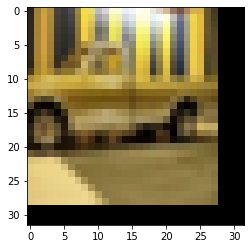

label: deer


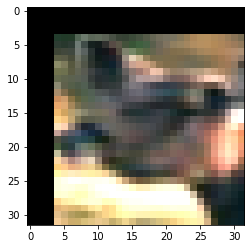

label: bird


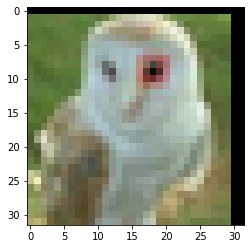

label: dog


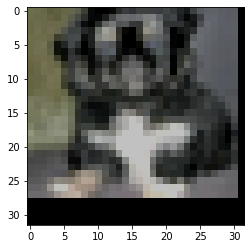

label: ship


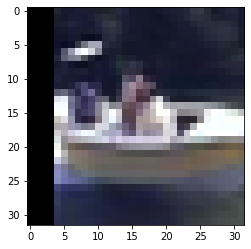

label: cat


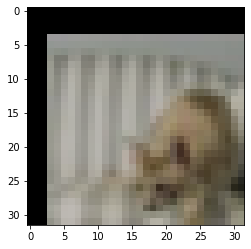

label: horse


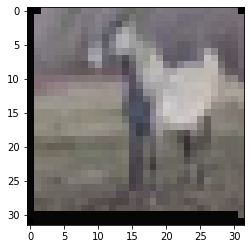

label: frog


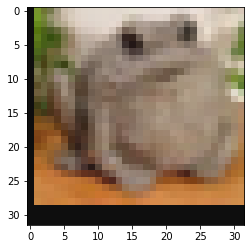

label: airplane


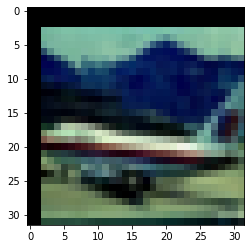

label: automobile


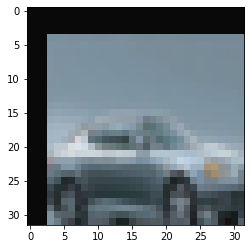

In [5]:
labels = {i for i in range(10)}
for image, target in train_loader: 
    for j in range(len(target)): 
        im, targ = image[j], target[j]
        if targ.item() in labels: 
            print("label: {}".format(da.CIFAR_LABELS[targ.item()]))
            plt.imshow(transforms.ToPILImage(mode="RGB")(im.squeeze(0)))
            plt.show()
            labels.remove(targ.item())
        if len(labels) == 0: 
            break

# Load in Base Classifier and Define Filtering Mechanism

In [6]:
base_classifier, base_sd = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=BASE_CLASSIFIER_PATH)
base_classifier = base_classifier.to(args.device)
phi = oracle.Logit_Ball_Complement(args.logit_ball)
gumbel = Gumbel(0, 1)

=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/base/b78013b8-fc41-41c9-8682-763299796454/checkpoint.pt.best'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/base/b78013b8-fc41-41c9-8682-763299796454/checkpoint.pt.best' (epoch 101)


# Truncate Dataset 

In [5]:
class TruncatedCIFAR(Dataset):
    """
    Truncated CIFAR-10 dataset [Kri09]_.
    Original dataset has 50k training images and 10k testing images, with the
    following classes:
    * Airplane
    * Automobile
    * Bird
    * Cat
    * Deer
    * Dog
    * Frog
    * Horse
    * Ship
    * Truck
    .. [Kri09] Krizhevsky, A (2009). Learning Multiple Layers of Features
        from Tiny Images. Technical Report.
        
    Truncated dataset only includes images and labels from original dataset that fall within the truncation set.
    """
    def __init__(self, img, label, transform):
        """
        """
        self.img = img 
        self.label = label
        self.transform = transform
#         ds_kwargs = {
#             'num_classes': 10,
#             'mean': ch.tensor([0.4914, 0.4822, 0.4465]),
#             'std': ch.tensor([0.2023, 0.1994, 0.2010]),
#             'custom_class': datasets.CIFAR10,
#             'label_mapping': None,
#             'transform_train': da.TRAIN_TRANSFORMS_DEFAULT(32),
#             'transform_test': da.TEST_TRANSFORMS_DEFAULT(32),
#         }

    def __getitem__(self, idx):
        """
        """
        x = self.img[idx]
        y = self.label[idx]
        # data augmentation
        if self.transform: 
            x = self.transform(x)
            
        return x, y
    
    def __len__(self): 
        return self.img.size(0)
    
TRUNC_TRAIN_TRANSFORMS = lambda size: transforms.Compose([
        transforms.ToPILImage(mode="RGB"),
        transforms.RandomCrop(size, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(.25, .25, .25),
        transforms.RandomRotation(2),
        transforms.ToTensor(),
    ])

TRUNC_TEST_TRANSFORMS = lambda size: transforms.Compose([
    transforms.ToPILImage(mode="RGB"),
    transforms.Resize(size),
    transforms.CenterCrop(size),
    transforms.ToTensor()
])

In [6]:
# check if there exists a cifar 10 train truncated dataset already
if not os.path.isfile(DATA_PATH + 'trunc_train.pickle') or not os.path.isfile(DATA_PATH + 'trunc_test.pickle'):
    trunc_train_X, trunc_train_y = Tensor([]), Tensor([])
    # unseen test data
    trunc_test_X, trunc_test_y = Tensor([]), Tensor([])
    for inp, targ in train_loader: 
        inp, targ = inp.to(args.device), targ.to(args.device)
        logits, inp = base_classifier(inp)
        # add gumbel noise to the logits
        noised = logits.cpu() + gumbel.sample(logits.size())
        filtered = phi(noised)
        indices = filtered.nonzero(as_tuple=False).flatten()
        test_indices = (~filtered).nonzero(as_tuple=False).flatten()
        trunc_train_X, trunc_train_y = ch.cat([trunc_train_X, inp[indices].cpu()]), ch.cat([trunc_train_y, targ[indices].cpu()])
        trunc_test_X, trunc_test_y = ch.cat([trunc_test_X, inp[test_indices].cpu()]), ch.cat([trunc_test_y, targ[test_indices].cpu()])

    print("train alpha: ", trunc_train_X.size(0) / len(train_loader.dataset))
    trunc_train_loader = DataLoader(TruncatedCIFAR(trunc_train_X, trunc_train_y.long(), transform= TRUNC_TRAIN_TRANSFORMS(32)), num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)

    # train loader
    with open(DATA_PATH + 'trunc_train.pickle', 'wb') as f: 
        pickle.dump(trunc_train_loader, f)
else: 
    trunc_train_loader = pd.read_pickle(DATA_PATH + 'trunc_train.pickle')
trunc_train_loader

In [7]:
# check if there exists a cifar 10 valdation and test truncated dataset
if not os.path.isfile(DATA_PATH + 'trunc_val.pickle') or not os.path.isfile(DATA_PATH + 'trunc_test.pickle'):
    trunc_val_X, trunc_val_y = Tensor([]), Tensor([])

    for inp, targ in val_loader: 
        inp, targ = inp.to(args.device), targ.to(args.device)
        logits, inp = base_classifier(inp)
        # add gumbel noise to the logits
        noised = logits.cpu() + gumbel.sample(logits.size())
        filtered = phi(noised)
        indices = filtered.nonzero(as_tuple=False).flatten()
        test_indices = (~filtered).nonzero(as_tuple=False).flatten()
        trunc_val_X, trunc_val_y = ch.cat([trunc_val_X, inp[indices].cpu()]), ch.cat([trunc_val_y, targ[indices].cpu()])
        trunc_test_X, trunc_test_y = ch.cat([trunc_test_X, inp[test_indices].cpu()]), ch.cat([trunc_test_y, targ[test_indices].cpu()])

    print("val alpha: ", trunc_val_X.size(0) / len(val_loader.dataset))
    trunc_val_loader = DataLoader(TruncatedCIFAR(trunc_val_X, trunc_val_y.long(), transform=TRUNC_TEST_TRANSFORMS(32)), num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)
    # truncated test set (unseen data that the model has not been tested on)
    trunc_test_loader = DataLoader(TruncatedCIFAR(trunc_test_X, trunc_test_y.long(), transform=TRUNC_TEST_TRANSFORMS(32)), 
                             num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)

    # validation loader
    with open(DATA_PATH + 'trunc_val.pickle', 'wb') as f: 
        pickle.dump(trunc_val_loader, f)

    # test loader
    with open(DATA_PATH + 'trunc_test.pickle', 'wb') as f: 
        pickle.dump(trunc_test_loader, f)
else: 
    trunc_val_loader = pd.read_pickle(DATA_PATH + 'trunc_val.pickle')
    trunc_test_loader = pd.read_pickle(DATA_PATH + 'trunc_test.pickle')
trunc_val_loader, trunc_test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f19aab0d5f8>,
 <torch.utils.data.dataloader.DataLoader at 0x7f19aaa5e4a8>)

# Setup Store and Train Model

In [14]:
# logging store
out_store = store.Store(LOGIT_BALL_CLASSIFIER)
setup_store_with_metadata(args, out_store)
model, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)

# set oracle
args.__setattr__('phi', phi)
# set gradient 
args.__setattr__('custom_criterion', grad.TruncatedCE.apply)
config.args = args

Logging in: /home/pstefanou/cifar-10/resnet-18/logit_ball_complement/c406f0dd-0834-4c6d-a502-abeee70ec8e6


NameError: name 'phi' is not defined

# TruncatedCE with Logit Ball Oracle

In [30]:
# train
final_model = train.train_model(args, model, (trunc_train_loader, trunc_val_loader), store=out_store, parallel=args.parallel)
out_store.close()

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [31]:
reader = CollectionReader(LOGIT_BALL_CLASSIFIER)
metadata = reader.df('metadata')
logs = reader.df('logs')
reader.close()
logs.head()

100%|██████████| 1/1 [00:00<00:00, 57.98it/s]


,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,11.319184,76.483605,10.149530,13.337933,26.747918,2db180cf-3a72-4e99-bbbe-f09318a014d5
1,2,10.164377,2.950814,10.650717,9.355806,53.802789,2db180cf-3a72-4e99-bbbe-f09318a014d5
2,3,12.172284,4.777610,10.126843,4.573220,80.060995,2db180cf-3a72-4e99-bbbe-f09318a014d5
3,4,12.411569,2.284973,10.801278,2.307458,106.224278,2db180cf-3a72-4e99-bbbe-f09318a014d5
4,5,18.497711,2.177071,14.227080,2.245956,132.653999,2db180cf-3a72-4e99-bbbe-f09318a014d5


# Accuracy and Loss Curves

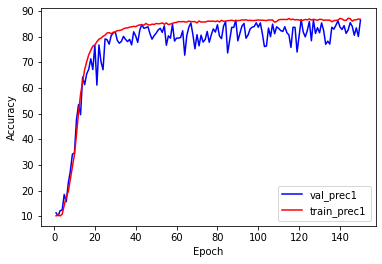

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

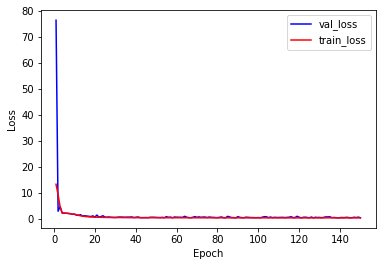

In [32]:
sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val_prec1', color='b')
ax = sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train_prec1', color='r')
ax.set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

sns.lineplot(data=logs, x='epoch', y='val_loss', label='val_loss', color='b')
ax = sns.lineplot(data=logs, x='epoch', y='train_loss', label='train_loss', color='r')
ax.set(xlabel='Epoch', ylabel='Loss')

# Train Standard Classifier on Resnet18

In [33]:
standard_model, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)
# logging store
out_store = store.Store(STANDARD_CLASSIFIER)
setup_store_with_metadata(args, out_store)
args.__setattr__('custom_criterion', None)

Logging in: /home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement/da76ebd0-781a-497f-ad80-66a1d6dde363


In [34]:
# train
final_model = train.train_model(args, standard_model, (trunc_train_loader, trunc_val_loader), store=out_store, parallel=args.parallel)
out_store.close()

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [35]:
reader = CollectionReader(STANDARD_CLASSIFIER)
metadata = reader.df('metadata')
logs = reader.df('logs')
reader.close()
logs.head()

100%|██████████| 3/3 [00:00<00:00, 95.03it/s]

new schema missing keys: {'custom_criterion', 'phi'}, new keys: set()


,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,28.156137,2.318036,26.956646,1.998040,25.823513,25863295-7881-4576-b39f-b17b7e78e8c0
1,2,33.990757,1.863739,35.214535,1.740180,51.626203,25863295-7881-4576-b39f-b17b7e78e8c0
2,3,30.374935,2.851786,44.453033,1.502972,77.583997,25863295-7881-4576-b39f-b17b7e78e8c0
3,4,49.922958,1.539556,51.575691,1.331879,103.409716,25863295-7881-4576-b39f-b17b7e78e8c0
4,5,52.223934,1.615280,61.868046,1.061062,129.335698,25863295-7881-4576-b39f-b17b7e78e8c0


In [39]:
logs = logs[logs['exp_id'] == 'da76ebd0-781a-497f-ad80-66a1d6dde363']

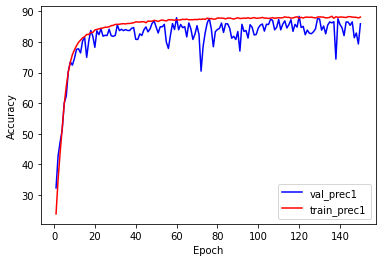

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

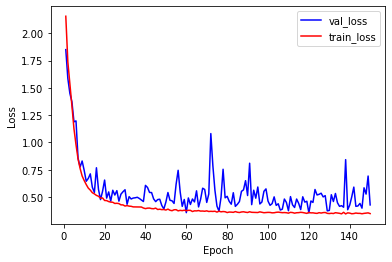

In [40]:
sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val_prec1', color='b')
ax = sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train_prec1', color='r')
ax.set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

sns.lineplot(data=logs, x='epoch', y='val_loss', label='val_loss', color='b')
ax = sns.lineplot(data=logs, x='epoch', y='train_loss', label='train_loss', color='r')
ax.set(xlabel='Epoch', ylabel='Loss')

# Load in Model

In [10]:
base = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=BASE_CLASSIFIER_PATH)
delphi_ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=LOGIT_BALL_CLASSIFIER + '/2db180cf-3a72-4e99-bbbe-f09318a014d5//checkpoint.pt.best')
standard =  model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=STANDARD_CLASSIFIER + '/da76ebd0-781a-497f-ad80-66a1d6dde363/checkpoint.pt.best')

=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/base/b78013b8-fc41-41c9-8682-763299796454/checkpoint.pt.best'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/base/b78013b8-fc41-41c9-8682-763299796454/checkpoint.pt.best' (epoch 101)
=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/logit_ball_complement/2db180cf-3a72-4e99-bbbe-f09318a014d5//checkpoint.pt.best'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/logit_ball_complement/2db180cf-3a72-4e99-bbbe-f09318a014d5//checkpoint.pt.best' (epoch 1)
=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement/da76ebd0-781a-497f-ad80-66a1d6dde363/checkpoint.pt.best'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement/da76ebd0-781a-497f-ad80-66a1d6dde363/checkpoint.pt.best' (epoch 1)


# Test Accuracy

In [11]:
delphi_store = store.Store(LOGIT_BALL_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/logit_ball_complement/849aea61-5204-4e60-af37-a0d0bef542ef


In [13]:
delphi_results = train.eval_model(args, delphi_[0], trunc_test_loader, delphi_store)
delphi_results

before model loop.


  0%|          | 0/18 [00:00<?, ?it/s]

after loop.


{'test_prec1': tensor(8.4501, device='cuda:0'),
 'test_loss': 127.10474744486099,
 'time': 0.8344764709472656}

In [14]:
base_results = train.eval_model(args, base[0], trunc_test_loader, delphi_store)
base_results

before model loop.


  0%|          | 0/18 [00:00<?, ?it/s]

after loop.


{'test_prec1': tensor(77.3643, device='cuda:0'),
 'test_loss': 0.7049828260458497,
 'time': 0.6995029449462891}

In [15]:
standard_results = train.eval_model(args, standard[0], trunc_test_loader, delphi_store)
standard_results

before model loop.


  0%|          | 0/18 [00:00<?, ?it/s]

after loop.


{'test_prec1': tensor(18.8266, device='cuda:0'),
 'test_loss': 2.3970705644470587,
 'time': 0.7213971614837646}